In [1]:
%pip install sklearn-crfsuite
%pip install gensim nltk
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from sklearn_crfsuite import CRF,metrics
import gensim
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from nltk import download
download('wordnet')

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\basav\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.27.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\basav\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.27.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\basav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# TASK 2.2: Identifying Topics Associated with Climate-Related Risks


In this task, we perform topic modelling on the climate sentiment dataset to identify themes associated with climate-related risks and opportunities. We use Latent Dirichlet Allocation (LDA) to uncover underlying topics from the training data. Our goal is to group similar documents based on their thematic structure and interpret key topics linked to risk and opportunity disclosures.

We compare two variations of the LDA model by adjusting critical parameters such as the number of topics and preprocessing steps. The results are visualized to show dominant topics per class, and limitations of the approach are discussed. This helps us understand both the effectiveness and challenges of applying unsupervised topic modelling in the climate disclosure domain.


In [2]:
import torch
import random
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility

### SET YOUR SEED TO YOUR STUDENT NUMBER HERE
my_student_number = 2542000
set_seed(my_student_number)

In [3]:
%reload_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Climate dataset
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split 

In [4]:
cache_dir = "./data_cache"
import logging
logging.basicConfig(level=logging.DEBUG)
set_seed(my_student_number)

# load the original training set from HuggingFace
train_dataset = load_dataset(
    "climatebert/climate_sentiment",
    split="train",
    cache_dir=cache_dir,
)

# Creating a new validation set by splitting the data
dataset_splits = train_dataset.train_test_split(test_size=0.2)
train_dataset = dataset_splits["train"]
val_dataset = dataset_splits["test"]

train_texts = np.array(train_dataset["text"])
val_texts = np.array(val_dataset["text"])

train_labels = np.array(train_dataset["label"])
val_labels = np.array(val_dataset["label"])

print(f"Training dataset with {len(train_texts)} instances loaded")
print(f"Development/validation dataset with {len(val_texts)} instances loaded")

risk_docs = [text for text, label in zip(train_texts, train_labels) if label == 0]
opportunity_docs = [text for text, label in zip(train_texts, train_labels) if label == 2]


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/climatebert/climate_sentiment HTTP/1.1" 200 2282
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/climatebert/climate_sentiment/climatebert/climate_sentiment.py HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/climatebert/climate_sentiment HTTP/1.1" 200 2282
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/climatebert/climate_sentiment/resolve/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2/README.md HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: d:/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete/climate_sentiment-train-00000-00000-of-NNNNN.arrow


Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: d:/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete/climate_sentiment-test-00000-00000-of-NNNNN.arrow
DEBUG:filelock:Attempting to acquire lock 2494990940048 on d:\2542000\data_cache\climatebert___climate_sentiment\default\0.0.0\f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete_info.lock
DEBUG:filelock:Lock 2494990940048 acquired on d:\2542000\data_cache\climatebert___climate_sentiment\default\0.0.0\f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete_info.lock
DEBUG:fsspec.local:open file: d:/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete/dataset_info.json
DEBUG:filelock:Attempting to release lock 2494990940048 on d:\2542000\data_cache\climatebert___climate_sentiment\default\0.0.0\f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete_info.lock
DEBUG:filelock:Lock 2494990940048 released on d:\2542000\data_cache\climateber

Training dataset with 800 instances loaded
Development/validation dataset with 200 instances loaded


In [5]:
#Preprocessing the documents to remove stopwords and lemmatize the words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS 
import numpy as np
from gensim.corpora import Dictionary
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    result=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

# A list of preprocessed documents
processed_risk_docs = [preprocess(doc) for doc in risk_docs]

from gensim.corpora import Dictionary
#Create a dictionary representation of the documents.
risk_dictionary = Dictionary(processed_risk_docs) 
print(risk_dictionary)

#Convert documents into bag-of-words vectors
bow_corpus = [risk_dictionary.doc2bow(doc) for doc in processed_risk_docs] 

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:built Dictionary<2296 unique tokens: ['air', 'automotive', 'choice', 'concern', 'congestion']...> from 268 documents (total 11587 corpus positions)
DEBUG:gensim.utils:starting a new internal lifecycle event log for Dictionary
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<2296 unique tokens: ['air', 'automotive', 'choice', 'concern', 'congestion']...> from 268 documents (total 11587 corpus positions)", 'datetime': '2025-04-28T01:38:50.982143', 'gensim': '4.3.3', 'python': '3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}


Dictionary<2296 unique tokens: ['air', 'automotive', 'choice', 'concern', 'congestion']...>


In [6]:
from gensim.models import LdaModel
set_seed(my_student_number)
# Construct and fit (train) the LDA model:
def train_lda_model(bow_corpus, risk_dictionary,num_topics):
  lda_model =  LdaModel(bow_corpus, 
                        num_topics=num_topics, 
                        id2word=risk_dictionary,                                    
                        passes=10,
                        random_state=my_student_number
                    
                      ) 

  #Checking the relative weight of words appearing in each of the topic
  for idx, topic in lda_model.print_topics(-1):
      print("Topic: {} \nWords: {}".format(idx, topic ))
      print("\n")

  return lda_model

lda_model_5 = train_lda_model(bow_corpus, risk_dictionary, num_topics=5)


INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 268 documents, updating model once every 268 documents, evaluating perplexity every 268 documents, iterating 50x with a convergence threshold of 0.001000
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-9.004 per-word bound, 513.5 perplexity estimate based on a held-out corpus of 268 documents with 11587 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #268/268
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 268 documents
DEBUG:gensim.models.ldamodel:29/268 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.031*"climate" + 0.029*"risk" + 0.024*"change" 

Topic: 0 
Words: 0.035*"risk" + 0.033*"climate" + 0.031*"change" + 0.022*"increase" + 0.019*"impact" + 0.013*"physical" + 0.011*"cost" + 0.010*"weather" + 0.010*"events" + 0.009*"result"


Topic: 1 
Words: 0.038*"risk" + 0.015*"carbon" + 0.013*"impact" + 0.011*"climate" + 0.009*"environmental" + 0.007*"relate" + 0.007*"transition" + 0.006*"emissions" + 0.006*"include" + 0.006*"change"


Topic: 2 
Words: 0.012*"impact" + 0.009*"energy" + 0.008*"risk" + 0.008*"scenario" + 0.006*"include" + 0.006*"gas" + 0.006*"company" + 0.006*"cause" + 0.005*"service" + 0.005*"business"


Topic: 3 
Words: 0.014*"impact" + 0.011*"environmental" + 0.010*"company" + 0.010*"include" + 0.009*"risk" + 0.008*"climate" + 0.007*"social" + 0.007*"change" + 0.007*"project" + 0.007*"damage"


Topic: 4 
Words: 0.052*"risk" + 0.019*"climate" + 0.018*"change" + 0.011*"management" + 0.009*"business" + 0.007*"energy" + 0.007*"financial" + 0.007*"company" + 0.006*"group" + 0.006*"assessment"




DEBUG:matplotlib:matplotlib data path: c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\basav\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\basav\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\basav\.matplotlib\fontlist-v390.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\basav\\anaconda3\\envs\\text_analytics\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size=

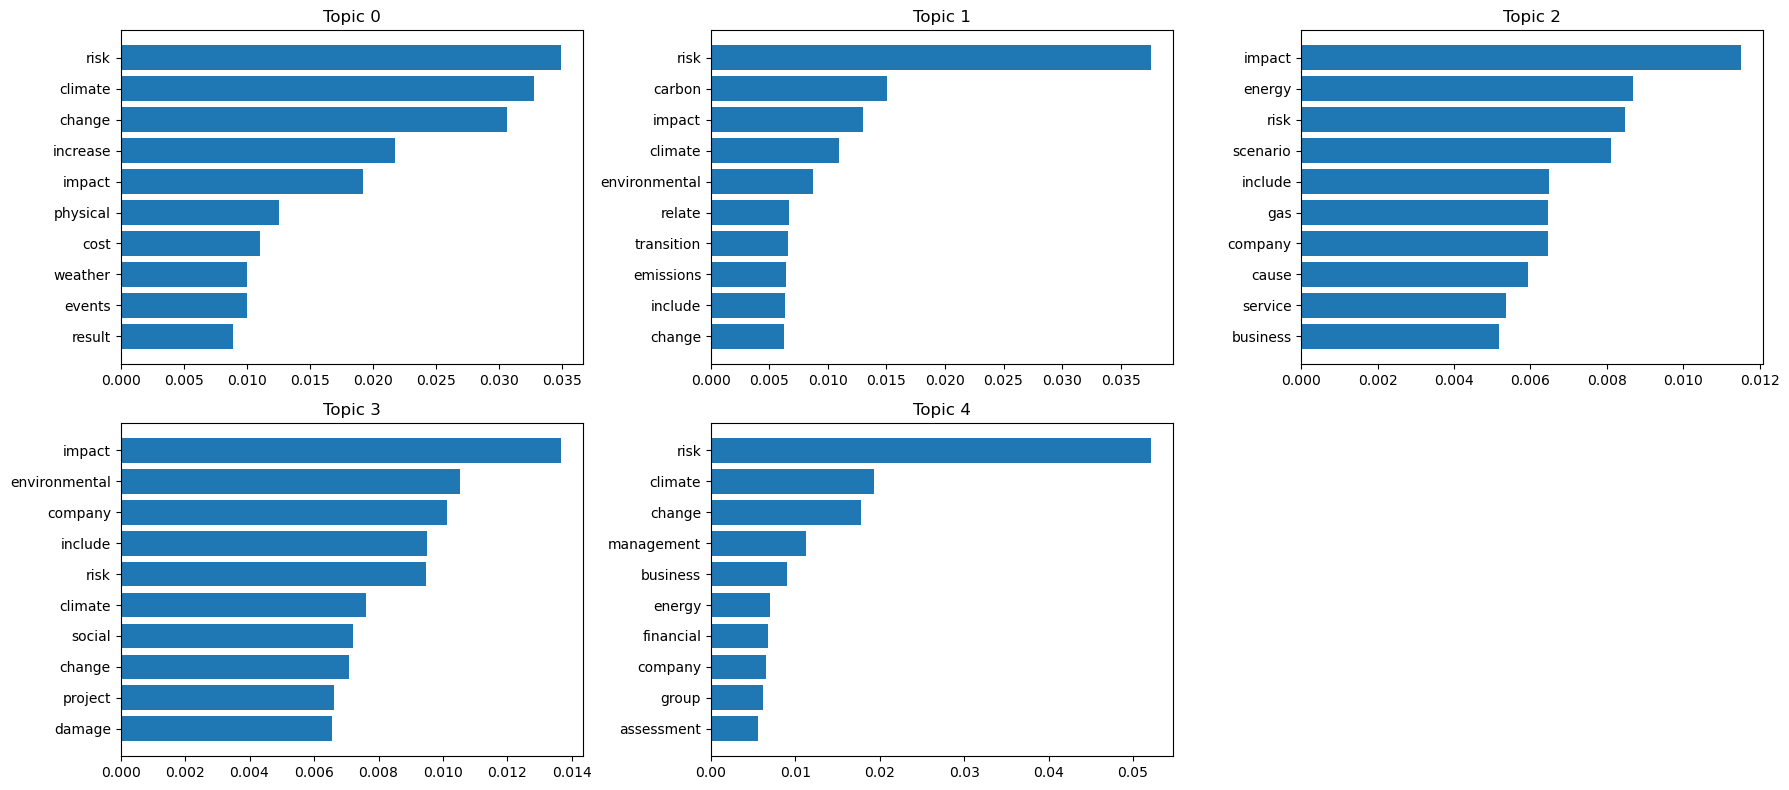

In [7]:
import matplotlib.pyplot as plt

def plot_lda_topics(lda_model, num_topics=10, num_words=10):
    topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    
    cols = 3 
    rows = (num_topics + cols - 1) // cols  
    plt.figure(figsize=(cols*6, rows*4))

    for idx, (topic_no, topic_words) in enumerate(topics):
        plt.subplot(rows, cols, idx+1)
        
        words = [word for word, _ in topic_words]
        probs = [prob for _, prob in topic_words]

        plt.barh(words, probs)
        plt.gca().invert_yaxis() 
        plt.title(f"Topic {topic_no}")

    plt.tight_layout()
    plt.show()

plot_lda_topics(lda_model_5, num_topics=5, num_words=10)



In [8]:
from gensim.models import CoherenceModel

def compute_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

coherence_5 = compute_coherence(lda_model_5, processed_risk_docs, risk_dictionary)

print(f"Coherence score for 5 topics: {coherence_5:.4f}")


DEBUG:gensim.models.coherencemodel:Setting topics to those of the model: LdaModel<num_terms=2296, num_topics=5, decay=0.5, chunksize=2000>
INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrenceAccumulator<processes=11, batch_size=64> to estimate probabilities from sliding windows
INFO:gensim.topic_coherence.text_analysis:11 accumulators retrieved from output queue
INFO:gensim.topic_coherence.text_analysis:accumulated word occurrence stats for 491 virtual documents


Coherence score for 5 topics: 0.3564


INFO:gensim.models.ldamodel:using symmetric alpha at 0.1
INFO:gensim.models.ldamodel:using symmetric eta at 0.1
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 268 documents, updating model once every 268 documents, evaluating perplexity every 268 documents, iterating 50x with a convergence threshold of 0.001000
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-10.631 per-word bound, 1585.7 perplexity estimate based on a held-out corpus of 268 documents with 11587 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #268/268
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 268 documents
DEBUG:gensim.models.ldamodel:66/268 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:topic #2 (0.100): 0.012*"energy" + 0.010*"impact" + 0.008*"risk

Topic: 0 
Words: 0.027*"climate" + 0.027*"increase" + 0.023*"change" + 0.018*"risk" + 0.016*"cost" + 0.013*"impact" + 0.010*"result" + 0.010*"financial" + 0.009*"group" + 0.008*"relate"


Topic: 1 
Words: 0.020*"risk" + 0.019*"carbon" + 0.017*"environmental" + 0.016*"project" + 0.014*"impact" + 0.010*"regulations" + 0.010*"emissions" + 0.010*"oil" + 0.009*"cost" + 0.007*"credit"


Topic: 2 
Words: 0.015*"energy" + 0.008*"new" + 0.008*"cause" + 0.008*"cost" + 0.007*"electricity" + 0.007*"coal" + 0.006*"gas" + 0.006*"scenario" + 0.006*"emissions" + 0.005*"reduction"


Topic: 3 
Words: 0.017*"company" + 0.015*"include" + 0.014*"risk" + 0.013*"impact" + 0.012*"environmental" + 0.010*"social" + 0.009*"change" + 0.008*"management" + 0.008*"divest" + 0.007*"increase"


Topic: 4 
Words: 0.035*"risk" + 0.019*"climate" + 0.015*"management" + 0.013*"change" + 0.011*"global" + 0.010*"group" + 0.010*"financial" + 0.008*"company" + 0.008*"insurance" + 0.007*"carbon"


Topic: 5 
Words: 0.031*"change"

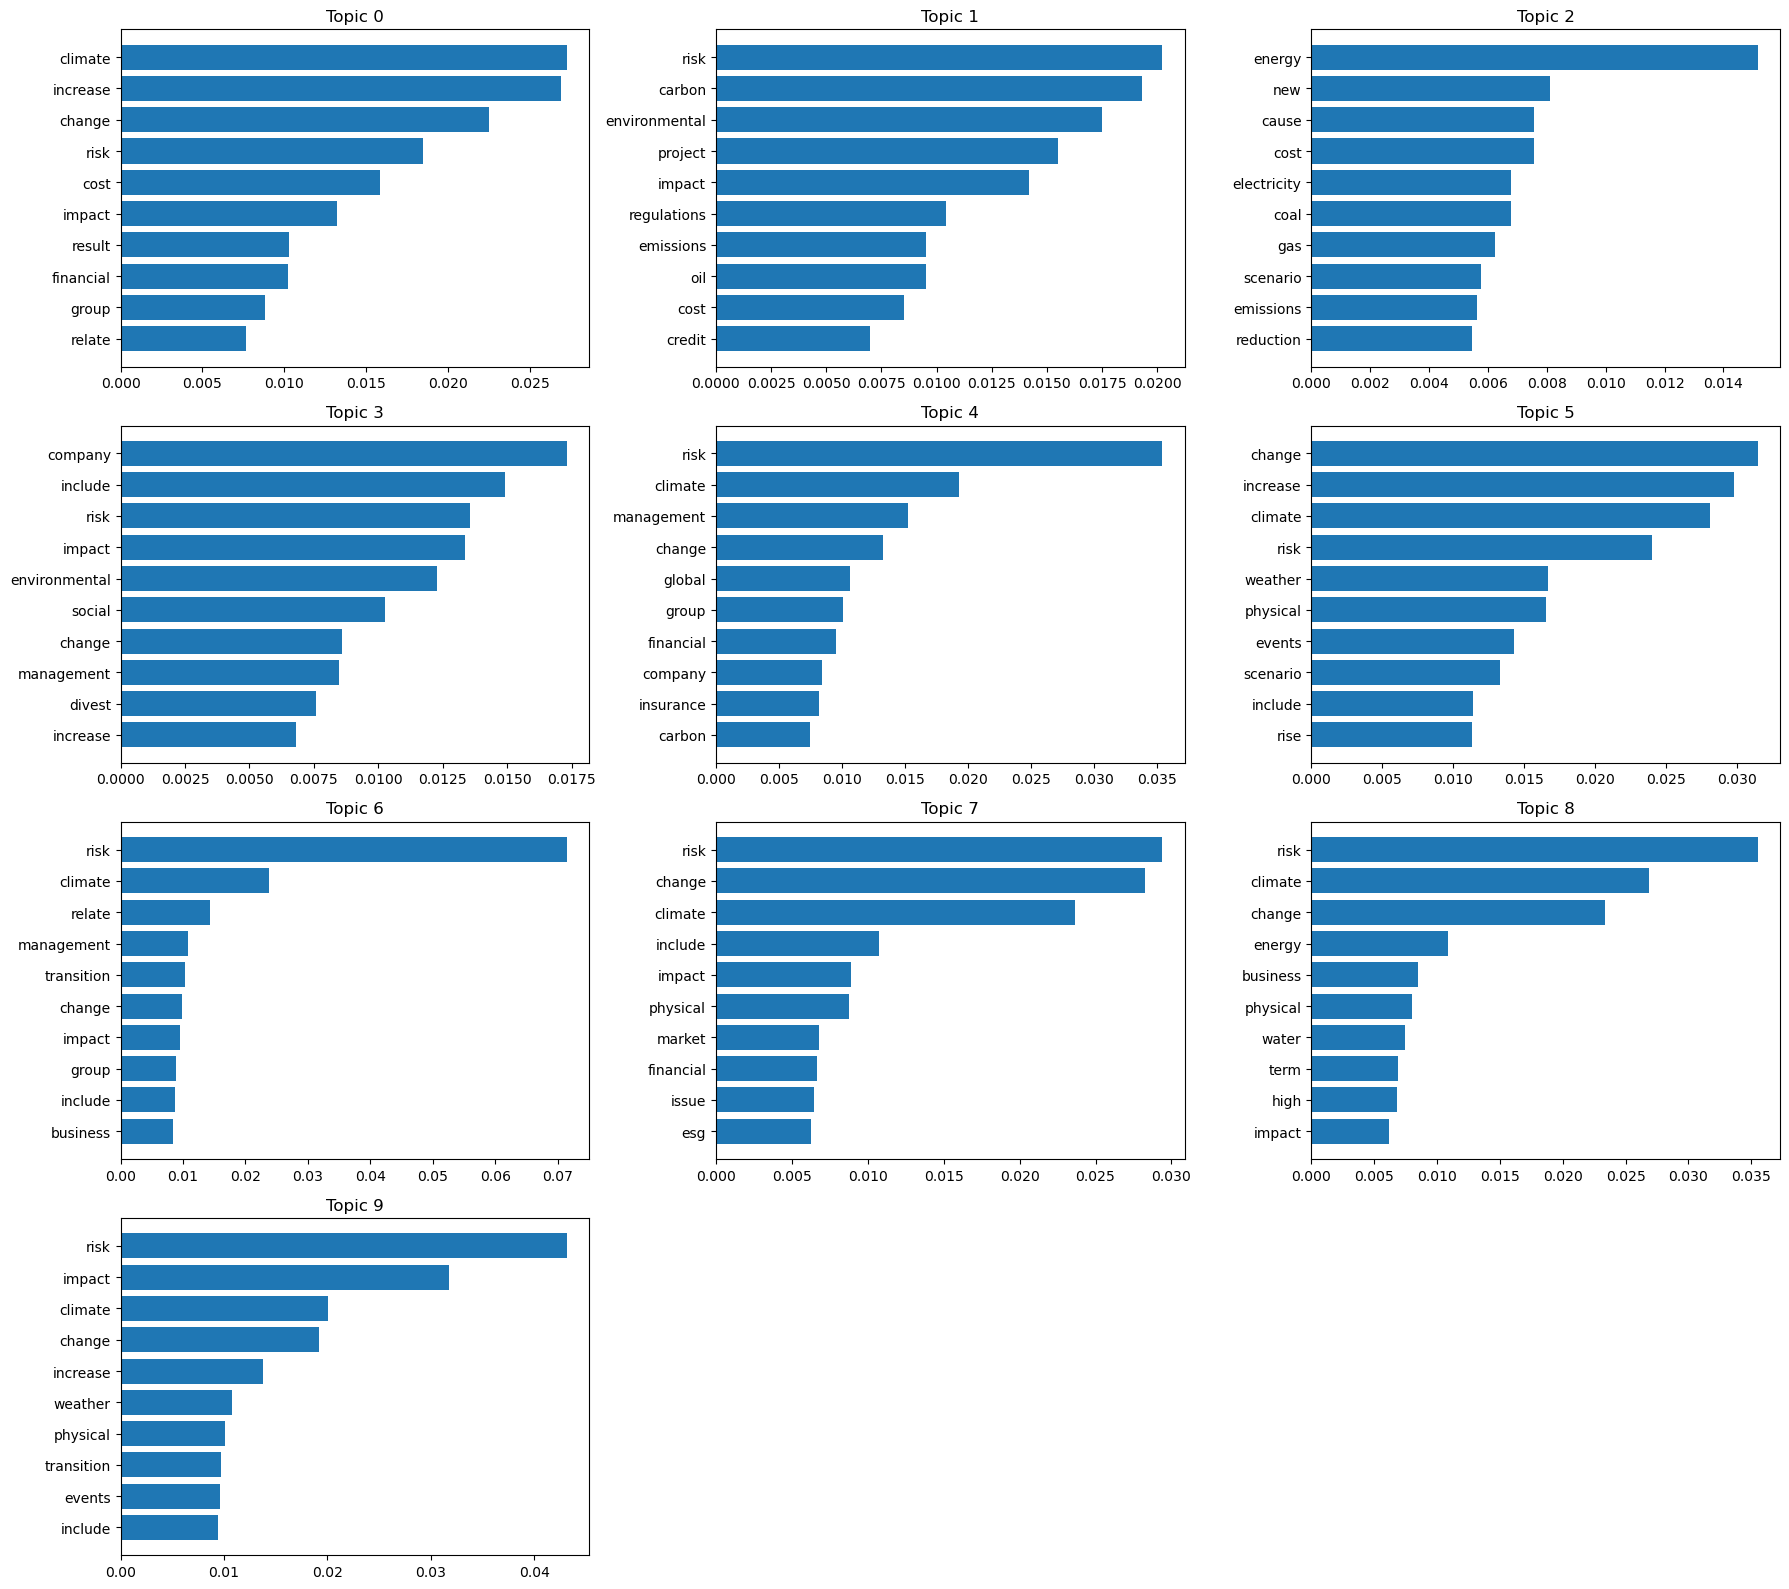

DEBUG:gensim.models.coherencemodel:Setting topics to those of the model: LdaModel<num_terms=2296, num_topics=10, decay=0.5, chunksize=2000>
INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrenceAccumulator<processes=11, batch_size=64> to estimate probabilities from sliding windows
INFO:gensim.topic_coherence.text_analysis:11 accumulators retrieved from output queue
INFO:gensim.topic_coherence.text_analysis:accumulated word occurrence stats for 491 virtual documents


Coherence score for 10 topics: 0.4081


In [9]:
lda_model_10= train_lda_model(bow_corpus, risk_dictionary, num_topics=10)

plot_lda_topics(lda_model_10, num_topics=10, num_words=10)
# plot_lda_topics_static(lda_model, num_topics=4, num_words=10)

from gensim.models import CoherenceModel

def compute_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

coherence_10 = compute_coherence(lda_model_10, processed_risk_docs, risk_dictionary)

print(f"Coherence score for 10 topics: {coherence_10:.4f}")

In [10]:
from gensim.models import TfidfModel


# Building a TF-IDF model
tfidf_model = TfidfModel(bow_corpus)

# Transforming BoW corpus to TF-IDF corpus
tfidf_corpus = tfidf_model[bow_corpus]

#  Now training LDA on TF-IDF corpus instead of the BoW corpus
lda_model_tfidf = LdaModel(
    corpus=tfidf_corpus, 
    id2word=risk_dictionary, 
    num_topics=5, 
    passes=10,
    random_state=my_student_number
)


topics = lda_model_tfidf.print_topics()
for topic in topics:
    print(topic)

def compute_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

coherence_tfidf = compute_coherence(lda_model_tfidf, processed_risk_docs, risk_dictionary)
print(f"Coherence score for TF-IDF LDA model: {coherence_tfidf:.4f}")

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
DEBUG:gensim.utils:starting a new internal lifecycle event log for TfidfModel
INFO:gensim.utils:TfidfModel lifecycle event {'msg': 'calculated IDF weights for 268 documents and 2296 features (9382 matrix non-zeros)', 'datetime': '2025-04-28T01:39:45.525884', 'gensim': '4.3.3', 'python': '3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'initialize'}
INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 268 documents, updating model once every 268 documents, evaluating perplexity every 268 documents, iterating 50x with a convergenc

(0, '0.003*"risk" + 0.003*"increase" + 0.003*"change" + 0.003*"impact" + 0.003*"climate" + 0.003*"cost" + 0.002*"operate" + 0.002*"effect" + 0.002*"weather" + 0.002*"physical"')
(1, '0.003*"carbon" + 0.002*"increase" + 0.002*"emissions" + 0.002*"risk" + 0.002*"result" + 0.002*"price" + 0.002*"environmental" + 0.002*"regulations" + 0.002*"products" + 0.002*"fuel"')
(2, '0.003*"include" + 0.003*"risk" + 0.002*"physical" + 0.002*"flood" + 0.002*"clients" + 0.002*"acute" + 0.002*"cause" + 0.002*"chronic" + 0.002*"damage" + 0.002*"impact"')
(3, '0.002*"carbon" + 0.002*"company" + 0.002*"divest" + 0.002*"transition" + 0.002*"increase" + 0.002*"bank" + 0.002*"rise" + 0.002*"energy" + 0.002*"relate" + 0.002*"sector"')
(4, '0.003*"risk" + 0.002*"change" + 0.002*"business" + 0.002*"climate" + 0.002*"page" + 0.002*"financial" + 0.002*"management" + 0.002*"provide" + 0.002*"water" + 0.002*"face"')


INFO:gensim.topic_coherence.text_analysis:11 accumulators retrieved from output queue
INFO:gensim.topic_coherence.text_analysis:accumulated word occurrence stats for 491 virtual documents


Coherence score for TF-IDF LDA model: 0.4241


DEPRECATION: Loading egg at c:\users\basav\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.27.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\basav\\anaconda3\\envs\\text_analytics\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\basav\\anaconda3\\envs\\text_analytics\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\basav\\anaconda3\\envs\\text_analytics\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal

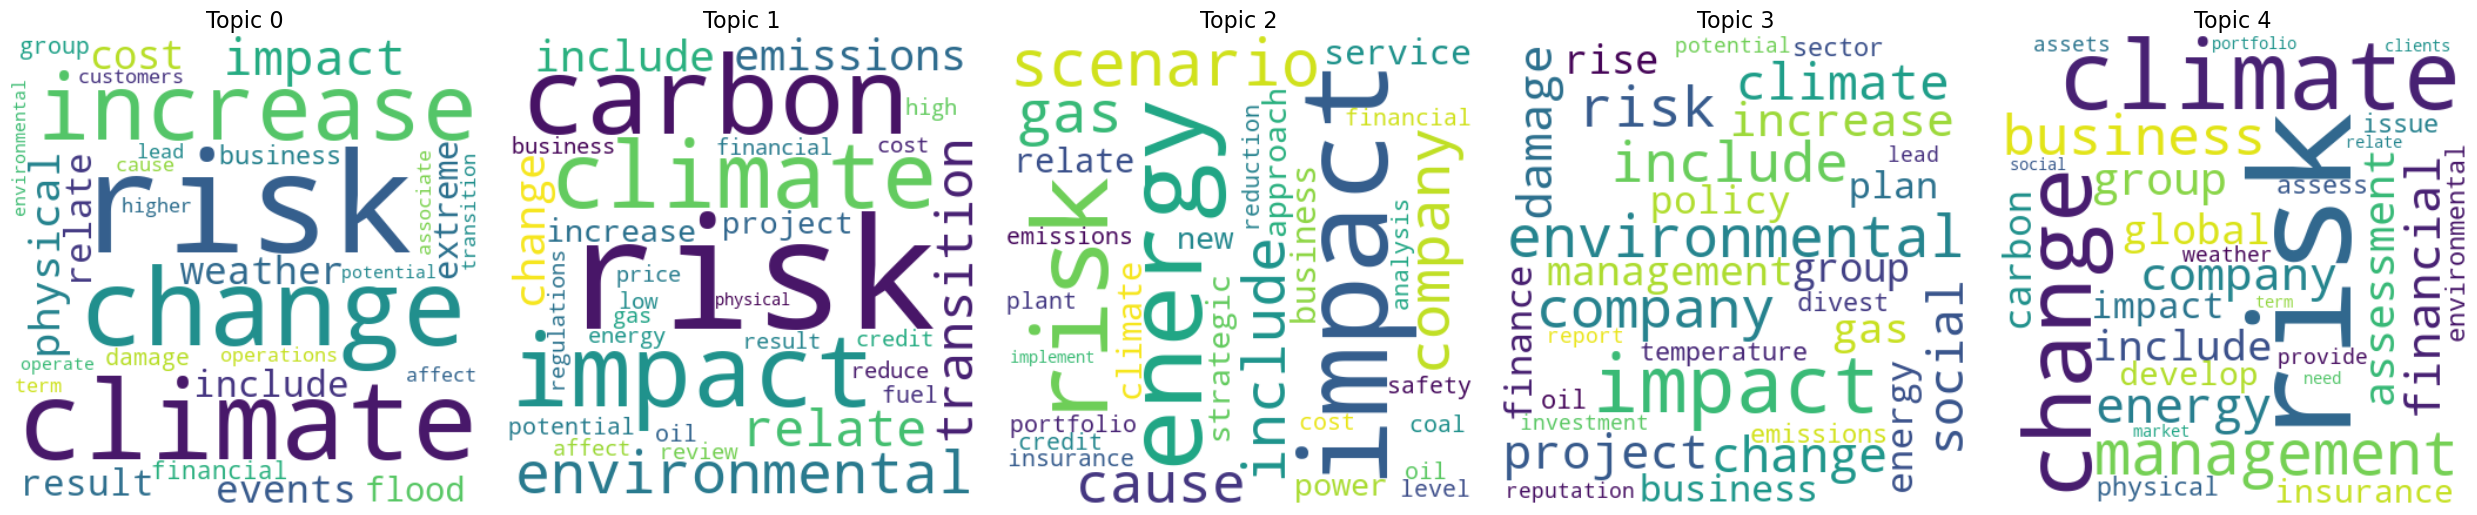

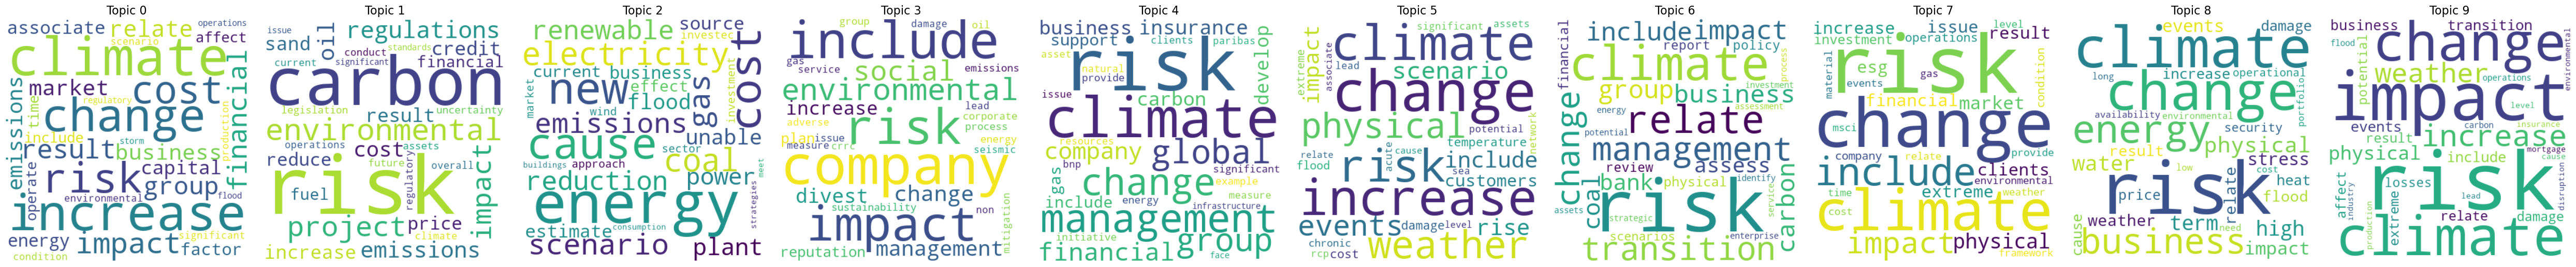

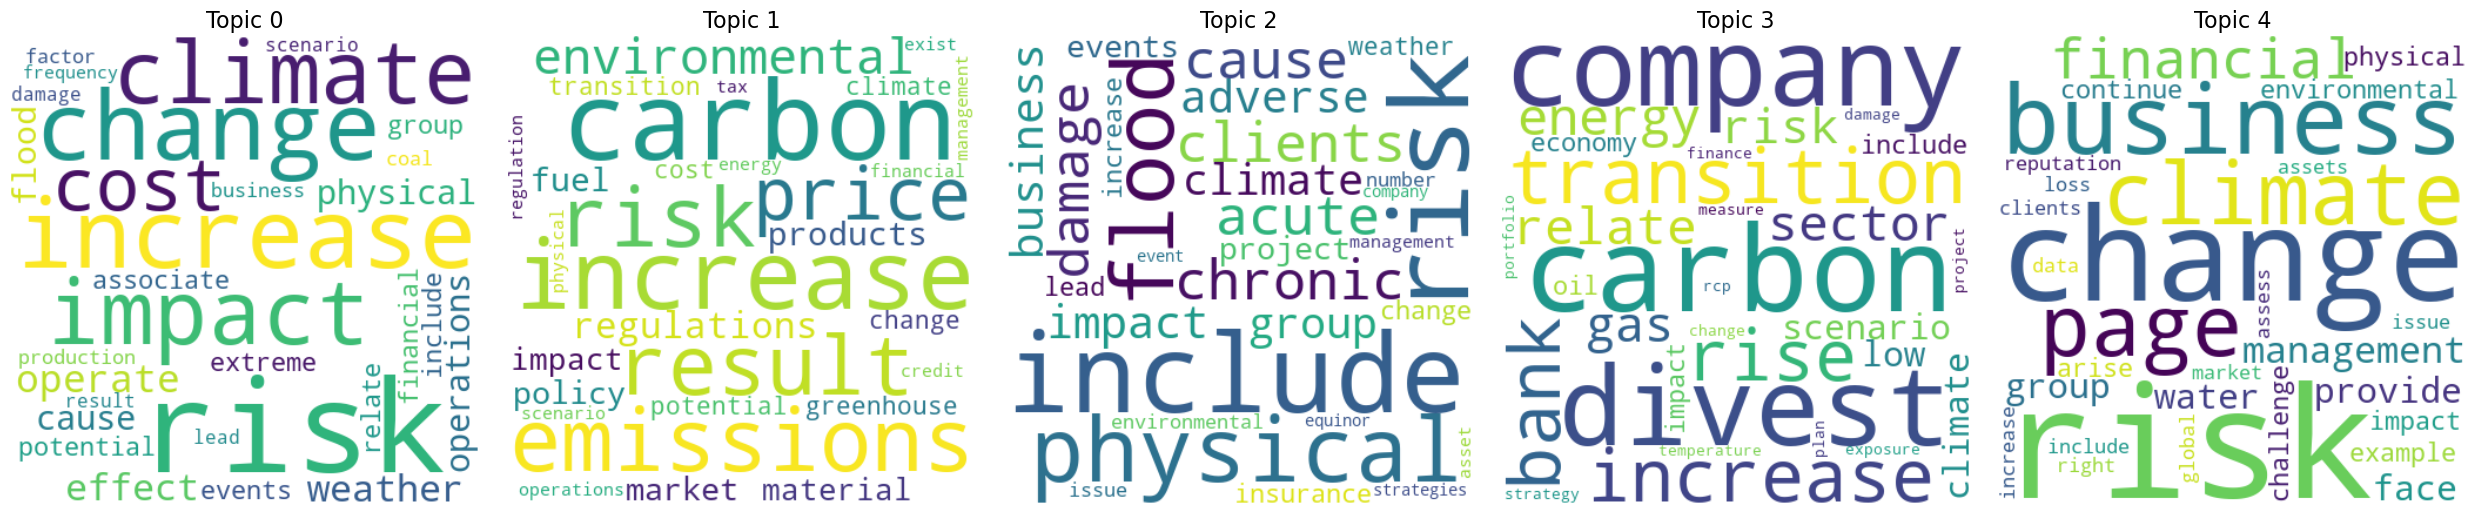

In [11]:
%pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(lda_model, num_topics):
    
    fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 5))
    
    if num_topics == 1:
        axes = [axes]
    
    for idx, ax in enumerate(axes):
        words = dict(lda_model.show_topic(idx, topn=30))  # top 30 words
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(words)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic {idx}", fontsize=16)
    
    plt.tight_layout()
    plt.show()


plot_wordclouds(lda_model_5, num_topics=5)
plot_wordclouds(lda_model_10, num_topics=10)
plot_wordclouds(lda_model_tfidf, num_topics=5)


In [12]:
# Set the index below to choose a document:
test_document_idx = 0

# Retrieve the document and print its newsgroup:
unseen_document = val_texts[test_document_idx]
unseen_label = val_labels[test_document_idx]
print(unseen_document)
print(unseen_label)

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
bow_vector = risk_dictionary.doc2bow(preprocess(unseen_document))

# Show a bag of words representation of the object:
for idx, count in bow_vector:
    print(f'{risk_dictionary[idx]}: {count}')

The long-term ambition is clear (to align its businesses with the Paris Agree- ment goals), but to achieve that ambition calls for short and medium-term targets in more specific bu- siness lines, allowing the Group to steer its various business operations with greater precision.
1
group: 1
specific: 1
business: 1
medium: 1
line: 1
operations: 1
ambition: 2
target: 1
businesses: 1
align: 1
allow: 1
ment: 1
long: 1
term: 2
achieve: 1
greater: 1
paris: 1
clear: 1
short: 1
steer: 1
goals: 1


In [13]:
topic_distribution = lda_model_5[bow_vector]
for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model_5.print_topic(index, 5)))


Index: 0
Probability: 0.45795613527297974	 Topic: 0.035*"risk" + 0.033*"climate" + 0.031*"change" + 0.022*"increase" + 0.019*"impact"
Index: 4
Probability: 0.3570798933506012	 Topic: 0.052*"risk" + 0.019*"climate" + 0.018*"change" + 0.011*"management" + 0.009*"business"
Index: 2
Probability: 0.16802620887756348	 Topic: 0.012*"impact" + 0.009*"energy" + 0.008*"risk" + 0.008*"scenario" + 0.006*"include"


In [14]:
from gensim.matutils import any2sparse

def get_document_ids(val_labels, target_label):
    """
    Returns the indices of documents in train_labels that match the target_label.
    """
    doc_idxs = [i for i, label in enumerate(val_labels) if label == target_label]
    return doc_idxs



def get_topic_dists(val_labels, val_texts, lda_model, dictionary, target_label, max_num_docs=10):
    doc_idxs = get_document_ids(val_labels, target_label)

    # Limit number of documents if needed
    if len(doc_idxs) > max_num_docs:
        doc_idxs = doc_idxs[:max_num_docs]

    topic_dists = []

    for idx in doc_idxs:
        bow = dictionary.doc2bow(preprocess(train_texts[idx]))
        doc_topics = lda_model.get_document_topics(bow)
        topic_dists.append(doc_topics)

    return topic_dists

    # Save each theta_d distribution to the list 'thetas':
    thetas = []
    
    for doc_idx in doc_idxs:
        ### COMPLETE THE CODE HERE
        
        # Get the document from newsgroups_train
        unseen_document = train_texts.data[doc_idx]
        
        # Apply preprocessing to get a bag-of-words vector:
        bow_vector = risk_dictionary.doc2bow(preprocess(unseen_document))
        
        # Use the LDA model to compute the topic distribution for this document:
        theta_d = lda_model_5[bow_vector]
        
        #######################
        
        thetas.append(theta_d)
    
    return thetas

In [15]:
 # 0 = risk, 1 = neutral, 2 = opportunity
thetas = get_topic_dists(val_labels, val_texts, lda_model_5, risk_dictionary, target_label=0)

print(thetas)

[[(0, 0.010682279), (1, 0.12143286), (2, 0.010608223), (3, 0.010888979), (4, 0.8463876)], [(0, 0.27825165), (1, 0.1978526), (3, 0.18218064), (4, 0.3343916)], [(1, 0.22534116), (2, 0.22494648), (4, 0.531868)], [(0, 0.0119390655), (1, 0.3915157), (2, 0.17319681), (3, 0.012035107), (4, 0.4113133)], [(3, 0.9746992)], [(4, 0.9661276)], [(0, 0.1564579), (1, 0.011374688), (2, 0.011647454), (3, 0.011596329), (4, 0.8089236)], [(2, 0.97973424)], [(0, 0.21006256), (1, 0.14723663), (2, 0.14747237), (4, 0.49172002)], [(0, 0.17208576), (1, 0.47434652), (2, 0.18002452), (3, 0.015782693), (4, 0.15776052)]]


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# choose some colours for the topics
colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'teal', 'pink', 'purple',
           'orange', 'gray', 'lime', 'darkgreen', 'lightgray', 'navy', 'gold', 'crimson', 'darkgray', 'fuchsia']

def convert_theta_sparse_to_dense(theta_d_sparse, num_topics):
    theta_d = np.zeros(num_topics)  # an empty array
    
    # split the output from lda_model into two lists
    active_topics_in_d, probs = map(list, zip(*theta_d_sparse))
    
    # record the values in theta_d
    for i, topic in enumerate(active_topics_in_d):
        if topic >= num_topics:
            break
            
        theta_d[topic] = probs[i]
    
    return theta_d

# a function for producing a bar chart for a document
def plot_theta(thetas, d, num_docs, num_topics):
    plt.subplot(int(num_docs/3) + 1, 3, d+1)   # make a set of subplots inside a figure, with four subplots per row
    
    theta_d = convert_theta_sparse_to_dense(thetas[d], num_topics)
    
    # plot the results so that the same topics always occur at the same place along the x axis.
    plt.bar(x=np.arange(len(theta_d)), height=theta_d, color=colours, tick_label=np.arange(num_topics))

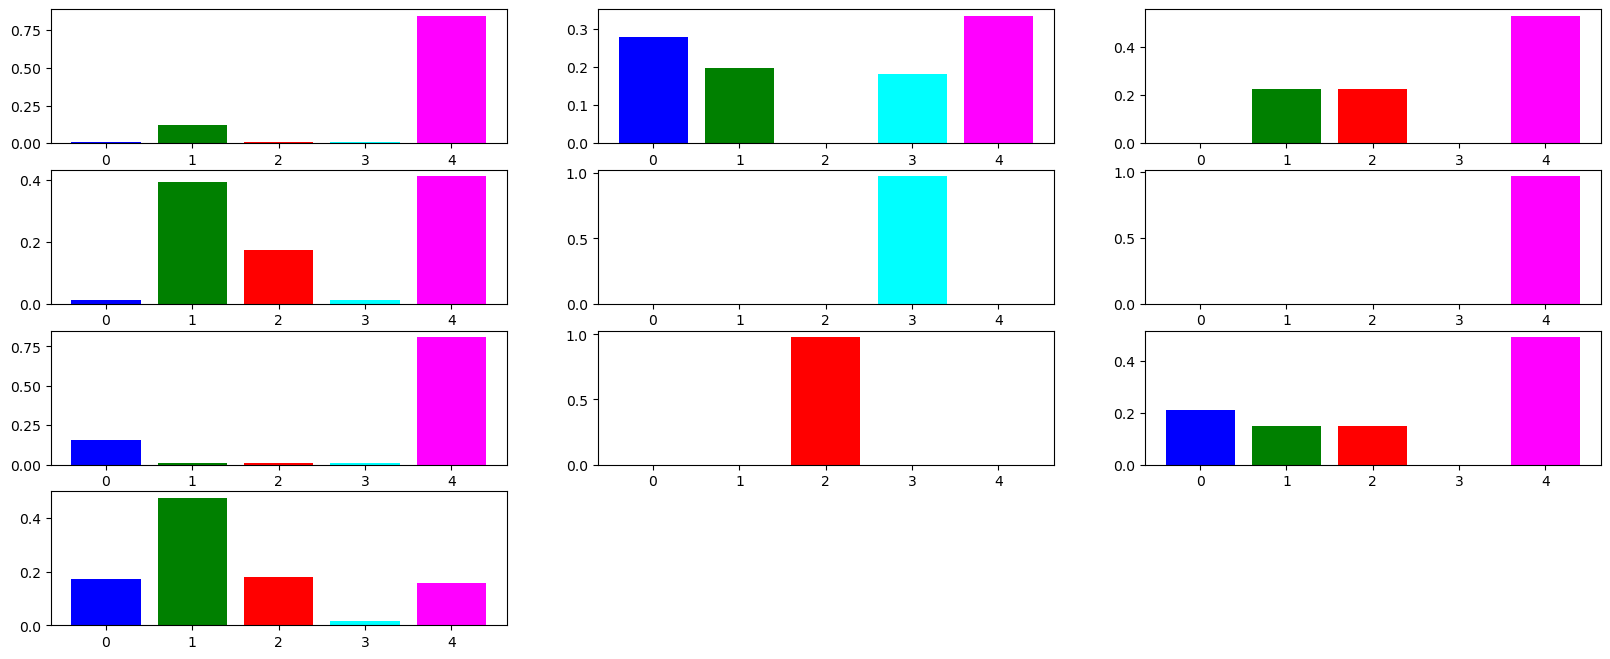

In [17]:
plt.figure(figsize=(20,8))

### WRITE YOUR OWN CODE HERE
num_docs = 10
num_topics = 5
for d, theta in enumerate(thetas):
    plot_theta(thetas, d, num_docs, num_topics)

############################

plt.show()

In [18]:
from collections import Counter

def get_dominant_topic_distribution(thetas):
    dominant_topics = [max(dist, key=lambda x: x[1])[0] for dist in thetas]
    return Counter(dominant_topics)

risk_topic_counts = get_dominant_topic_distribution(thetas)
# opp_topic_counts = get_dominant_topic_distribution(opp_thetas)

print("Risk topics:", risk_topic_counts)
# print("Opportunity topics:", opp_topic_counts)


Risk topics: Counter({4: 7, 3: 1, 2: 1, 1: 1})


# TASK 3: Named Entity Recognition for Board Twitter Corpus dataset

In [20]:
from datasets import load_dataset

cache_dir = "./data_cache"

# The data is already divided into training and test sets.
# Load the training set:
train_dataset = load_dataset(
    "tner/btc",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")

# Load the test set:
val_dataset = load_dataset(
    "tner/btc",
    split="validation",
    cache_dir=cache_dir,
)
print(f" Validation dataset with {len(val_dataset)} instances loaded")


# Load the test set:
test_dataset = load_dataset(
    "tner/btc",
    split="test",
    cache_dir=cache_dir,
)
print(f" Test dataset with {len(test_dataset)} instances loaded")


train_dataset[0]


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/tner/btc HTTP/1.1" 200 2648
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/tner/btc HTTP/1.1" 200 2648
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/tner/btc/tree/main?recursive=False&expand=False HTTP/1.1" 200 387
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /datasets/tner/btc/resolve/main/btc.py HTTP/1.1" 200 3908
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/tner/btc/tner/btc.py HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): datasets-server.huggingface.co:443
DEBUG:urllib3.connectionpool:https://datasets-server.huggingface.co:443 "GET /parquet?dataset=tner/btc HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): datasets-server.hugg

Generating train split:   0%|          | 0/6338 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: d:/2542000/data_cache/tner___btc/btc/1.0.1/06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete/btc-train-00000-00000-of-NNNNN.arrow


Generating validation split:   0%|          | 0/1001 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: d:/2542000/data_cache/tner___btc/btc/1.0.1/06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete/btc-validation-00000-00000-of-NNNNN.arrow


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: d:/2542000/data_cache/tner___btc/btc/1.0.1/06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete/btc-test-00000-00000-of-NNNNN.arrow
DEBUG:filelock:Attempting to acquire lock 2494991124816 on d:\2542000\data_cache\tner___btc\btc\1.0.1\06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete_info.lock
DEBUG:filelock:Lock 2494991124816 acquired on d:\2542000\data_cache\tner___btc\btc\1.0.1\06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete_info.lock
DEBUG:fsspec.local:open file: d:/2542000/data_cache/tner___btc/btc/1.0.1/06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete/dataset_info.json
DEBUG:filelock:Attempting to release lock 2494991124816 on d:\2542000\data_cache\tner___btc\btc\1.0.1\06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete_info.lock
DEBUG:filelock:Lock 2494991124816 released on d:\2542000\data_cache\tner___btc\btc\1.0.1\06bc381446b3c3cb1faaa56c5575c71f101e286a.incomplete_info.lock
DEBUG:filelock:Attempting to release lock 2495105169040 on d:\2542

Training dataset with 6338 instances loaded


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/tner/btc/tner/btc.py HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): datasets-server.huggingface.co:443
DEBUG:urllib3.connectionpool:https://datasets-server.huggingface.co:443 "GET /parquet?dataset=tner/btc HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): datasets-server.huggingface.co:443
DEBUG:urllib3.connectionpool:https://datasets-server.huggingface.co:443 "GET /info?dataset=tner/btc HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/tner/btc/revision/refs%2Fconvert%2Fparquet HTTP/1.1" 200 613
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/tner/btc/revision/bf9990f452c33f722c0b

 Validation dataset with 1001 instances loaded


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/tner/btc/tner/btc.py HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): datasets-server.huggingface.co:443
DEBUG:urllib3.connectionpool:https://datasets-server.huggingface.co:443 "GET /parquet?dataset=tner/btc HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): datasets-server.huggingface.co:443
DEBUG:urllib3.connectionpool:https://datasets-server.huggingface.co:443 "GET /info?dataset=tner/btc HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/tner/btc/revision/refs%2Fconvert%2Fparquet HTTP/1.1" 200 613
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/tner/btc/revision/bf9990f452c33f722c0b

 Test dataset with 2000 instances loaded


{'tokens': ['I',
  'hate',
  'the',
  'words',
  'chunder',
  ',',
  'vomit',
  'and',
  'puke',
  '.',
  'BUUH',
  '.'],
 'tags': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]}

In [21]:
ner_tag_mapping = {0: 'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5:'B-LOC', 6:'I-LOC', 7:'B-MISC', 8:'I-MISC'}

train_set = [list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in train_dataset][:-1]
test_set = [list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in test_dataset][:-1]
test_tokens = [s['tokens'] for s in test_dataset][:-1]
test_tags = [[ner_tag_mapping[tok] for tok in s['tags']] for s in test_dataset][:-1]


In [22]:
import nltk

# Train a CRF NER tagger
def train_CRF_NER_tagger(train_set):
    ### WRITE YOUR OWN CODE HERE
    tagger = nltk.tag.CRFTagger()
    tagger.train(train_set, 'model.crf.tagger')
    return tagger  # return the trained model

custom_tagger = train_CRF_NER_tagger(train_set)

In [23]:
predicted_tags = custom_tagger.tag_sents(test_tokens)

In [32]:
import numpy as np
def extract_spans(tagged_sents):

    spans = {}
        
    for sidx, sent in enumerate(tagged_sents):
        start = -1
        entity_type = None
        for i, (tok, lab) in enumerate(sent):
            if 'B-' in lab:
                start = i
                end = i + 1
                entity_type = lab[2:]
            elif 'I-' in lab:
                end = i + 1
            elif lab == 'O' and start >= 0:
                
                if entity_type not in spans:
                    spans[entity_type] = []
                
                spans[entity_type].append((start, end, sidx))
                start = -1      
        # Sometimes an I-token is the last token in the sentence, so we still have to add the span to the list
        if start >= 0:    
            if entity_type not in spans:
                spans[entity_type] = []
                
            spans[entity_type].append((start, end, sidx))
                
    return spans


def cal_span_level_f1(test_sents, test_sents_with_pred):
    # get a list of spans from the test set labels
    gold_spans = extract_spans(test_sents)

    # get a list of spans predicted by our tagger
    pred_spans = extract_spans(test_sents_with_pred)
    
    # compute the metrics for each class:
    f1_per_class = []
    
    ne_types = gold_spans.keys()  # get the list of named entity types (not the tags)
    
    for ne_type in ne_types:
        # compute the confusion matrix
        true_pos = 0
        false_pos = 0
        
        for span in pred_spans[ne_type]:
            if span in gold_spans[ne_type]:
                true_pos += 1
            else:
                false_pos += 1
                
        false_neg = 0
        for span in gold_spans[ne_type]:
            if span not in pred_spans[ne_type]:
                false_neg += 1
                
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / float(true_pos + false_pos)
            
        if true_pos + false_neg == 0:
            recall = 0
        else:
            recall = true_pos / float(true_pos + false_neg)
        
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
            
        f1_per_class.append(f1)
        print(f'F1 score for class {ne_type} = {f1}')
        
        
    print(f'Macro-average f1 score = {np.mean(f1_per_class)}')

results= cal_span_level_f1(test_set, predicted_tags)
results

F1 score for class PER = 0.15424164524421596
F1 score for class ORG = 0.2718446601941747
F1 score for class LOC = 0.2305084745762712
Macro-average f1 score = 0.21886492667155397


In [33]:
import re, unicodedata
import gensim
import nltk
from nltk.tag import CRFTagger

class CustomCRFTagger(nltk.tag.CRFTagger):
    _current_tokens = None
    _word2vec_model = None
    
    def __init__(self, word2vec_model_path=None):
      
        super().__init__()
        if word2vec_model_path:
            self._word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

    def _get_features(self, tokens, idx):
      
        token = tokens[idx]
        feature_list = []

        if not token:
            return feature_list

        # Basic Features
        # Capitalization
        if token[0].isupper():
            feature_list.append("CAPITALIZATION")

        # Number
        if re.search(self._pattern, token) is not None:
            feature_list.append("HAS_NUM")

        # Punctuation
        punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
        if all(unicodedata.category(x) in punc_cat for x in token):
            feature_list.append("PUNCTUATION")

        # Suffixes (last 3 characters)
        if len(token) > 1:
            feature_list.append("SUF_" + token[-1:])
        if len(token) > 2:
            feature_list.append("SUF_" + token[-2:])
        if len(token) > 3:
            feature_list.append("SUF_" + token[-3:])
        
        # Current word
        feature_list.append("WORD_" + token)

        # Contextual features (previous and next word)
        if idx > 0:
            feature_list.append("PREVWORD_" + tokens[idx-1])
        if idx < len(tokens)-1:
            feature_list.append("NEXTWORD_" + tokens[idx+1])
        
        # POS tags (previous and next word)
        pos_tags = nltk.pos_tag(tokens)
        if idx > 0:
            feature_list.append("PREV_POS_" + pos_tags[idx-1][1])  # POS of the previous token
        if idx < len(tokens) - 1:
            feature_list.append("NEXT_POS_" + pos_tags[idx+1][1])  # POS of the next token

        # Word embeddings (Word2Vec/GloVe)
        if self._word2vec_model:
            try:
                word_vector = self._word2vec_model[token]
                for i, value in enumerate(word_vector):
                    feature_list.append(f"WORD_EMBEDDING_{i}_{value}")
            except KeyError:
                # If word is not in the vocabulary, we do nothing
                pass

        # Character-level features (n-grams)
        def get_char_ngrams(word, n=3):
            return [word[i:i+n] for i in range(len(word)-n+1)]
        
        char_ngrams = get_char_ngrams(token)
        feature_list.extend([f"CHAR_NGRAM_{gram}" for gram in char_ngrams])

        return feature_list


In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite import scorers

def train_CustomCRF_NER_tagger(train_set, n_folds=3, tune_hyperparams=True):
    
    X_train = [sent2features(s) for sent in train_set]
    y_train = [sent2labels(s) for sent in train_set]
    
    # Initializing tagger with custom features
    tagger = CustomCRFTagger()
    
    if tune_hyperparams:
        # Defining hyperparameter space
        params_space = {
            'c1': [0.01, 0.1, 1.0, 10.0],  # L1 regularization
            'c2': [0.01, 0.1, 1.0, 10.0],  # L2 regularization
            'max_iterations': [50, 100, 200],
            'feature.possible_transitions': [True, False],
        }
        
        
        scorer = scorers.make_scorer(flat_f1_score, average='weighted')
        
        # Randomized search CV
        rs = RandomizedSearchCV(
            tagger._model, 
            params_space, 
            cv=n_folds,
            n_iter=20,
            scoring=scorer,
            verbose=1
        )
        rs.fit(X_train, y_train)
        
        # Updating the model with best params
        tagger._model = rs.best_estimator_
        print(f"Best params: {rs.best_params_}")
        print(f"Best CV score: {rs.best_score_:.3f}")
    else:
        # Regular training if not tuning
        tagger.train(train_set, 'model.crf.tagger')
    
    return tagger

In [35]:
# Train a CRF NER tagger
def train_CustomCRF_NER_tagger(train_set):
    ### WRITE YOUR OWN CODE HERE
    tagger = CustomCRFTagger()
    tagger.train(train_set, 'model.crf.tagger')
    return tagger  # return the trained model

optimised_tagger = train_CustomCRF_NER_tagger(train_set)

In [36]:
optimised_predicted_tags = optimised_tagger.tag_sents(test_tokens)
optimised_results= cal_span_level_f1(test_set, optimised_predicted_tags)
optimised_results

F1 score for class PER = 0.31453362255965295
F1 score for class ORG = 0.35748792270531404
F1 score for class LOC = 0.4649859943977591
Macro-average f1 score = 0.3790025132209087


In [37]:
from datasets import load_dataset


# Define the label2id dictionary to map numerical tags to BIO labels according to the dataset
label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6
}

# mapping the tag indices to BIO labels
id2label = {v: k for k, v in label2id.items()}

# Filter and display sentences with more than 'O' in entities
for example in train_dataset:
    tokens = example['tokens']
    tag_indices = example['tags']

    # Convert the tag indices to BIO labels
    tags = [id2label[index] for index in tag_indices]

    # Checking for non-'O' tags 
    if any(tag != 'O' for tag in tags):
        print(f"Tokens: {tokens}")
        print(f"BIO Tags: {tags}")
        print("-" * 40) 


Tokens: ['Think', 'you', 'call', 'that', 'smash', 'and', 'grab', '.', '#', 'Gateshead', "'s", 'media', 'man', 'just', 'admitted', 'to', 'me', 'it', 'was', '\'"\'', 'daylight', 'robbery', '\'"\'', '.', 'Shaw', "'s", 'only', 'touch', 'was', 'his', 'goal', '.']
BIO Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------
Tokens: ['middle', 'aged', 'man', 'band', 'playing', 'blink', '182', '.', 'l0', 'l', '.']
BIO Tags: ['O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O']
----------------------------------------
Tokens: ['How', 'did', 'Dorothy', 'Gale', 'come', 'back', '*', 'younger', '*', 'in', 'Return', 'to', 'Oz', '?', '?']
BIO Tags: ['O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------
Tokens: ['TD', 'Chargers', '=', '\\', '.', 'If', 'we', 'ca',

In [39]:
# Function to extract misclassified texts
def extract_misclassified_texts(test_set, predicted_tags):
    misclassified_texts = []

    for true_labels, pred_labels, sentence in zip(test_set, predicted_tags, test_tokens):
        # Compare the true and predicted labels for each sentence
        for true_label, pred_label, word in zip(true_labels, pred_labels, sentence):
            
            if true_label != pred_label:
                misclassified_texts.append({
                    'sentence': sentence,
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'word': word
                })
    
    return misclassified_texts


misclassified_texts = extract_misclassified_texts(test_set, predicted_tags)


for misclass in misclassified_texts[:10]:  # Print first 10 misclassified instances
    print(f"Sentence: {' '.join(misclass['sentence'])}")
    print(f"Word: {misclass['word']}")
    print(f"True Label: {misclass['true_label']}, Predicted Label: {misclass['pred_label']}")
    print('-' * 50)


Sentence: @ colgo hey , congrats to you and the team ! Always worth a read :)
Word: colgo
True Label: ('colgo', 'I-PER'), Predicted Label: ('colgo', 'I-LOC')
--------------------------------------------------
Sentence: This morning I met with Senators Inabo and Senior from Palau to discuss my role as Chair of the Public Works . . . http://t.co/McYNwpzHmt
Word: Inabo
True Label: ('Inabo', 'I-PER'), Predicted Label: ('Inabo', 'I-LOC')
--------------------------------------------------
Sentence: This morning I met with Senators Inabo and Senior from Palau to discuss my role as Chair of the Public Works . . . http://t.co/McYNwpzHmt
Word: Senior
True Label: ('Senior', 'I-PER'), Predicted Label: ('Senior', 'I-LOC')
--------------------------------------------------
Sentence: This morning I met with Senators Inabo and Senior from Palau to discuss my role as Chair of the Public Works . . . http://t.co/McYNwpzHmt
Word: Palau
True Label: ('Palau', 'O'), Predicted Label: ('Palau', 'I-LOC')
------